#### We're providing this notebook for you to go through and explore in your own time. To complete it you'll need to install both Thermobar and PySulfSat using the two cell codes below

In [ ]:
%pip install Thermobar

In [ ]:
%pip install PySulfSat

In [1]:
# import core python packages that we'll use for plotting and data manipulation.
import sys
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import platform

import petthermotools as ptt 
import Thermobar as pt
import PySulfSat as ss

ptt.__version__

'0.3.9'

In [3]:
## If using Mac run this cell **twice** 
if platform.system() == "Darwin":
    sys.stdout = open(os.devnull, 'w')
    sys.stderr = open(os.devnull, 'w')

## Integration of PetThermoTools with other Python projects

By expanding our workflow to include other Python tools we can learn even more about our systems. In this notebook we'll run some simple fractional crystallization models focusing on lavas from Kilauea, Hawai'i. After this we will work on visualizing the results - including mineral compositions - using Thermobar. At the end of the notebook we can then use PySulfSat to estimate the SCSS along our crystallization path.

First let's load in the data from Kilauea. This includes PEC-corrected compositions of olivine, plagioclase, and clinopyroxene hosted melt inclusions as well as matrix glass analyses from Wieser et al. (2022). Using the code below we can load in every sheet of the supplied excel file into a Python Dictionary. This Dictionary will contain a DataFrame for each sheet in the excel file. Type **Data.keys()** to see the name of the different DataFrames and find out what data we've just loaded. 

In [4]:
# Load all sheets into a dictionary of DataFrames
Data = pd.read_excel('Kilauea.xlsx', sheet_name=None)
Data.keys()

dict_keys(['Matrix Glass', 'Olivine', 'Clinopyroxene', 'Plagioclase'])

Let's plot the data to have a look at it. I've plotted up MgO vs SiO2 and MgO vs FeOt, add in two more graphs of your choice.

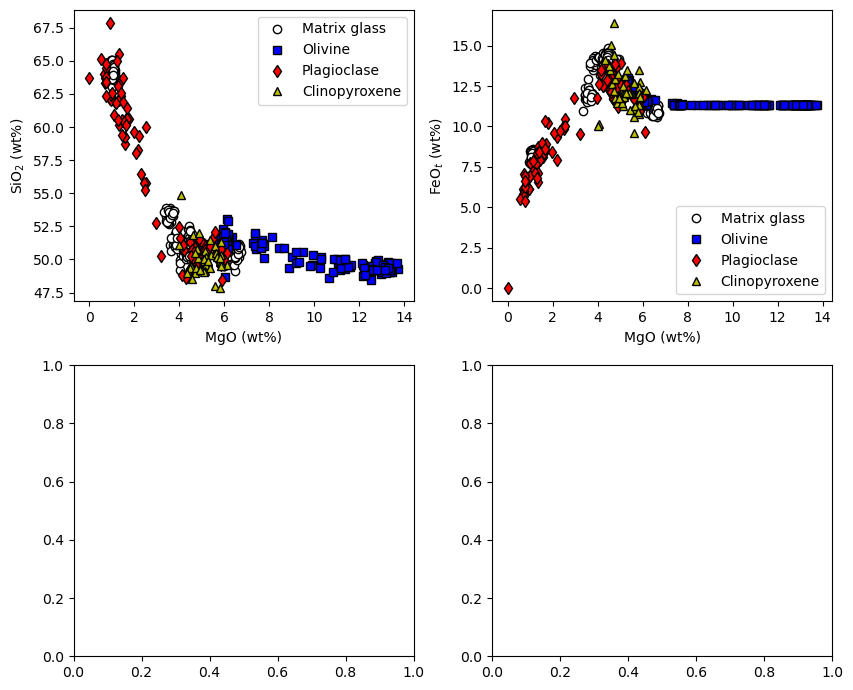

In [5]:
f, a = plt.subplots(2,2, figsize = (8.5, 7))
a[0][0].plot(Data['Matrix Glass']['MgO_Liq'], Data['Matrix Glass']['SiO2_Liq'], 'ok', mfc = 'w', label = 'Matrix glass')
a[0][0].plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['SiO2_Liq'], 'sk', mfc = 'b', label = 'Olivine')
a[0][0].plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['SiO2_Liq'], 'dk', mfc = 'r', label = 'Plagioclase')
a[0][0].plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['SiO2_Liq'], '^k', mfc = 'y', label = 'Clinopyroxene')

a[0][0].set_xlabel('MgO (wt%)')
a[0][0].set_ylabel('SiO$_2$ (wt%)')
a[0][0].legend()

a[0][1].plot(Data['Matrix Glass']['MgO_Liq'], Data['Matrix Glass']['FeOt_Liq'], 'ok', mfc = 'w', label = 'Matrix glass')
a[0][1].plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['FeOt_Liq'], 'sk', mfc = 'b', label = 'Olivine')
a[0][1].plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['FeOt_Liq'], 'dk', mfc = 'r', label = 'Plagioclase')
a[0][1].plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['FeOt_Liq'], '^k', mfc = 'y', label = 'Clinopyroxene')

a[0][1].set_xlabel('MgO (wt%)')
a[0][1].set_ylabel('FeO$_t$ (wt%)')
a[0][1].legend()

############## Add two plots for MgO against another element ###############


f.tight_layout()

# Part 1 - Fractional crystllization

To start we'll copy the work done by Wieser et al. (2022) and use the rhyolite-MELTS v1.2.0 model to simulate fractional crystallization starting at a composition characteristic of the matrix glass analyses with ~6 - 7 wt% MgO. This crystallization model approximates the formation of andesitic and dacitic magmas along the lower east rift zone of Kilauea.

In [11]:
# First let's set a bulk composition to use as the starting value. This was based on the most primitive compositions sampled. 
starting_comp = {'SiO2': 50.62,
                'TiO2': 2.56,
                'Al2O3': 13.31,
                'FeOt': 10.93,
                'MnO': 0.18,
                'MgO': 6.59,
                'CaO': 10.80,
                'Na2O': 2.37,
                'K2O': 0.48,
                'P2O5': 0.24}

############## Run this cell and plot the results in graphs below. Have a go at changing the parameters (H2O, fO2 etc.) and see
############## how these parameters influence the model results. ###############
Xtal_LERZ = ptt.isobaric_crystallisation(Model="MELTSv1.0.2",
                                         bulk= starting_comp,
                                         P_bar=650,
                                         T_end_C=900,
                                         dt_C=2,
                                         find_liquidus=True,
                                         Fe3Fet_init=0.18,
                                        #  fO2_buffer="FMQ",
                                        #  fO2_offset=-0.5,
                                         H2O_init=0.2,
                                         Frac_fluid=True,
                                         Frac_solid=True)

**Let's inspect the model outputs. The main output is a dictionary containing a number of DataFrames. We can see what's in a dictionary using the code below.**

In [12]:
# To see the different things inside a dictionary, you can do the name of the dictionary.keys
Xtal_LERZ.keys()

dict_keys(['Conditions', 'liquid1', 'liquid1_prop', 'clinopyroxene1', 'clinopyroxene1_prop', 'plagioclase1', 'plagioclase1_prop', 'clinopyroxene2', 'clinopyroxene2_prop', 'spinel1', 'spinel1_prop', 'rhm-oxide1', 'rhm-oxide1_prop', 'olivine1', 'olivine1_prop', 'apatite1', 'apatite1_prop', 'quartz1', 'quartz1_prop', 'All', 'PhaseList', 'mass_g', 'volume_cm3', 'rho_kg/m3'])

**We can also look at any of the individual DataFrames using those 'keys'. Perhaps unsurprising, 'All' is a combination of all the information.**

In [13]:
## We can then look at the dataframe stored within these keys. 'All' has all the information
Xtal_LERZ['All'].head()

,T_C,P_bar,mass_g,h_J,s_J/K,v_cm3,rho_kg/m3,log10(fO2),dvdp_cm3/bar,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq,mass_g_Liq,rho_kg/m3_Liq,v_cm3_Liq,g_J_Liq,h_J_Liq,s_J/K_Liq,cp_J/kg/K_Liq,dcpdt_J/K_Liq,dvdt_cm3/K_Liq,dpdt_bar/K_Liq,d2vdt2_cm3/K2_Liq,d2vdtdp_cm3/bar.K_Liq,d2vdp2_cm3/bar2_Liq,molwt_Liq,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,Cr2O3_Cpx,Fe2O3_Cpx,FeO_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,P2O5_Cpx,H2O_Cpx,CO2_Cpx,Fe3Fet_Cpx,mass_g_Cpx,rho_kg/m3_Cpx,v_cm3_Cpx,g_J_Cpx,h_J_Cpx,s_J/K_Cpx,cp_J/kg/K_Cpx,dcpdt_J/K_Cpx,dvdt_cm3/K_Cpx,dpdt_bar/K_Cpx,d2vdt2_cm3/K2_Cpx,d2vdtdp_cm3/bar.K_Cpx,d2vdp2_cm3/bar2_Cpx,molwt_Cpx,SiO2_Plag,TiO2_Plag,Al2O3_Plag,Cr2O3_Plag,Fe2O3_Plag,FeO_Plag,FeOt_Plag,MnO_Plag,MgO_Plag,CaO_Plag,Na2O_Plag,K2O_Plag,P2O5_Plag,H2O_Plag,CO2_Plag,Fe3Fet_Plag,mass_g_Plag,rho_kg/m3_Plag,v_cm3_Plag,g_J_Plag,h_J_Plag,s_J/K_Plag,cp_J/kg/K_Plag,dcpdt_J/K_Plag,dvdt_cm3/K_Plag,dpdt_bar/K_Plag,d2vdt2_cm3/K2_Plag,d2vdtdp_cm3/bar.K_Plag,d2vdp2_cm3/bar2_Plag,molwt_Plag,SiO2_Cpx2,TiO2_Cpx2,Al2O3_Cpx2,Cr2O3_Cpx2,Fe2O3_Cpx2,FeO_Cpx2,FeOt_Cpx2,MnO_Cpx2,MgO_Cpx2,CaO_Cpx2,Na2O_Cpx2,K2O_Cpx2,P2O5_Cpx2,H2O_Cpx2,CO2_Cpx2,Fe3Fet_Cpx2,mass_g_Cpx2,rho_kg/m3_Cpx2,v_cm3_Cpx2,g_J_Cpx2,h_J_Cpx2,s_J/K_Cpx2,cp_J/kg/K_Cpx2,dcpdt_J/K_Cpx2,dvdt_cm3/K_Cpx2,dpdt_bar/K_Cpx2,d2vdt2_cm3/K2_Cpx2,d2vdtdp_cm3/bar.K_Cpx2,d2vdp2_cm3/bar2_Cpx2,molwt_Cpx2,SiO2_Sp,TiO2_Sp,Al2O3_Sp,Cr2O3_Sp,Fe2O3_Sp,FeO_Sp,FeOt_Sp,MnO_Sp,MgO_Sp,CaO_Sp,Na2O_Sp,K2O_Sp,P2O5_Sp,H2O_Sp,CO2_Sp,Fe3Fet_Sp,mass_g_Sp,rho_kg/m3_Sp,v_cm3_Sp,g_J_Sp,h_J_Sp,s_J/K_Sp,cp_J/kg/K_Sp,dcpdt_J/K_Sp,dvdt_cm3/K_Sp,dpdt_bar/K_Sp,d2vdt2_cm3/K2_Sp,d2vdtdp_cm3/bar.K_Sp,d2vdp2_cm3/bar2_Sp,molwt_Sp,SiO2_Rhm,TiO2_Rhm,Al2O3_Rhm,Cr2O3_Rhm,Fe2O3_Rhm,FeO_Rhm,FeOt_Rhm,MnO_Rhm,MgO_Rhm,CaO_Rhm,Na2O_Rhm,K2O_Rhm,P2O5_Rhm,H2O_Rhm,CO2_Rhm,Fe3Fet_Rhm,mass_g_Rhm,rho_kg/m3_Rhm,v_cm3_Rhm,g_J_Rhm,h_J_Rhm,s_J/K_Rhm,cp_J/kg/K_Rhm,dcpdt_J/K_Rhm,dvdt_cm3/K_Rhm,dpdt_bar/K_Rhm,d2vdt2_cm3/K2_Rhm,d2vdtdp_cm3/bar.K_Rhm,d2vdp2_cm3/bar2_Rhm,molwt_Rhm,SiO2_Ol,TiO2_Ol,Al2O3_Ol,Cr2O3_Ol,Fe2O3_Ol,FeO_Ol,FeOt_Ol,MnO_Ol,MgO_Ol,CaO_Ol,Na2O_Ol,K2O_Ol,P2O5_Ol,H2O_Ol,CO2_Ol,Fe3Fet_Ol,mass_g_Ol,rho_kg/m3_Ol,v_cm3_Ol,g_J_Ol,h_J_Ol,s_J/K_Ol,cp_J/kg/K_Ol,dcpdt_J/K_Ol,dvdt_cm3/K_Ol,dpdt_bar/K_Ol,d2vdt2_cm3/K2_Ol,d2vdtdp_cm3/bar.K_Ol,d2vdp2_cm3/bar2_Ol,molwt_Ol,SiO2_Apa,TiO2_Apa,Al2O3_Apa,Cr2O3_Apa,Fe2O3_Apa,FeO_Apa,FeOt_Apa,MnO_Apa,MgO_Apa,CaO_Apa,Na2O_Apa,K2O_Apa,P2O5_Apa,H2O_Apa,CO2_Apa,Fe3Fet_Apa,mass_g_Apa,rho_kg/m3_Apa,v_cm3_Apa,g_J_Apa,h_J_Apa,s_J/K_Apa,cp_J/kg/K_Apa,dcpdt_J/K_Apa,dvdt_cm3/K_Apa,dpdt_bar/K_Apa,d2vdt2_cm3/K2_Apa,d2vdtdp_cm3/bar.K_Apa,d2vdp2_cm3/bar2_Apa,molwt_Apa,SiO2_Qtz,TiO2_Qtz,Al2O3_Qtz,Cr2O3_Qtz,Fe2O3_Qtz,FeO_Qtz,FeOt_Qtz,MnO_Qtz,MgO_Qtz,CaO_Qtz,Na2O_Qtz,K2O_Qtz,P2O5_Qtz,H2O_Qtz,CO2_Qtz,Fe3Fet_Qtz,mass_g_Qtz,rho_kg/m3_Qtz,v_cm3_Qtz,g_J_Qtz,h_J_Qtz,s_J/K_Qtz,cp_J/kg/K_Qtz,dcpdt_J/K_Qtz,dvdt_cm3/K_Qtz,dpdt_bar/K_Qtz,d2vdt2_cm3/K2_Qtz,d2vdtdp_cm3/bar.K_Qtz,d2vdp2_cm3/bar2_Qtz,molwt_Qtz
0,1169.377185,650.0,100.000000,-1.205208e+06,264.736725,37.272109,2682.971350,-8.203467,-0.000243,51.393844,2.599136,13.513474,0.0,2.218538,9.099614,11.095840,0.182752,6.690743,10.965103,2.406231,0.487338,0.243669,0.199558,0.0,0.179908,100.000000,2682.971350,37.272109,-1.587098e+06,-1.205208e+06,264.736725,1445.356146,0.001145,0.002698,NaN,6.568958e-08,-6.841595e-09,9.418828e-09,95.856205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.

**Now lets plot the data**

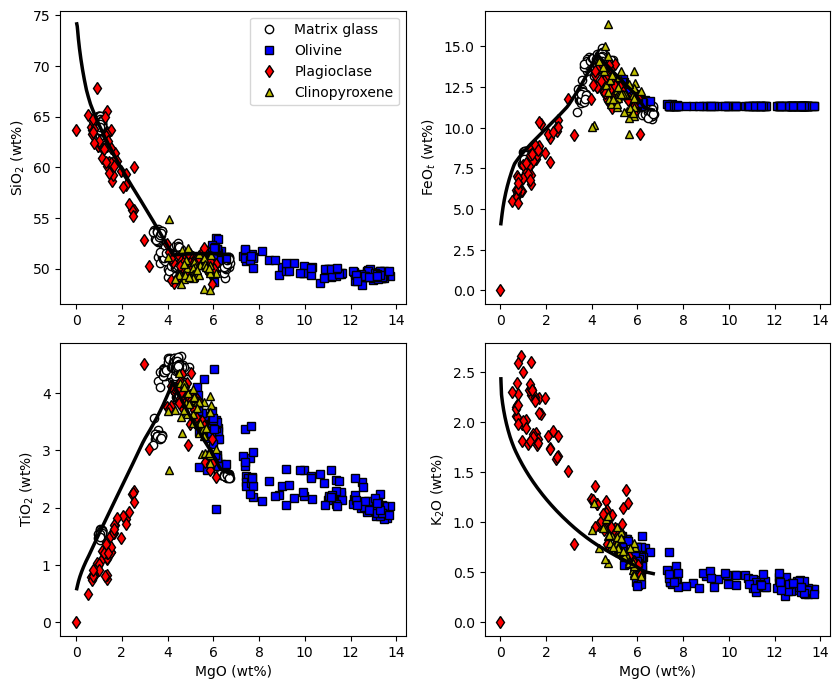

In [14]:
f, a = plt.subplots(2,2, figsize = (8.5, 7))
a[0][0].plot(Data['Matrix Glass']['MgO_Liq'], Data['Matrix Glass']['SiO2_Liq'], 'ok', mfc = 'w', label = 'Matrix glass')
a[0][0].plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['SiO2_Liq'], 'sk', mfc = 'b', label = 'Olivine')
a[0][0].plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['SiO2_Liq'], 'dk', mfc = 'r', label = 'Plagioclase')
a[0][0].plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['SiO2_Liq'], '^k', mfc = 'y', label = 'Clinopyroxene')
a[0][0].plot(Xtal_LERZ['All']['MgO_Liq'], Xtal_LERZ['All']['SiO2_Liq'], '-k', lw = 2.5)

# a[0][0].set_xlabel('MgO (wt%)')
a[0][0].set_ylabel('SiO$_2$ (wt%)')
a[0][0].legend()

a[0][1].plot(Data['Matrix Glass']['MgO_Liq'], Data['Matrix Glass']['FeOt_Liq'], 'ok', mfc = 'w', label = 'Matrix glass')
a[0][1].plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['FeOt_Liq'], 'sk', mfc = 'b', label = 'Olivine')
a[0][1].plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['FeOt_Liq'], 'dk', mfc = 'r', label = 'Plagioclase')
a[0][1].plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['FeOt_Liq'], '^k', mfc = 'y', label = 'Clinopyroxene')
a[0][1].plot(Xtal_LERZ['All']['MgO_Liq'], Xtal_LERZ['All']['FeOt_Liq'], '-k', lw = 2.5)

# a[0][1].set_xlabel('MgO (wt%)')
a[0][1].set_ylabel('FeO$_t$ (wt%)')


a[1][0].plot(Data['Matrix Glass']['MgO_Liq'], Data['Matrix Glass']['TiO2_Liq'], 'ok', mfc = 'w', label = 'Matrix glass')
a[1][0].plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['TiO2_Liq'], 'sk', mfc = 'b', label = 'Olivine')
a[1][0].plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['TiO2_Liq'], 'dk', mfc = 'r', label = 'Plagioclase')
a[1][0].plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['TiO2_Liq'], '^k', mfc = 'y', label = 'Clinopyroxene')
a[1][0].plot(Xtal_LERZ['All']['MgO_Liq'], Xtal_LERZ['All']['TiO2_Liq'], '-k', lw = 2.5)

a[1][0].set_xlabel('MgO (wt%)')
a[1][0].set_ylabel('TiO$_2$ (wt%)')

# a[1][1].plot(Data['Matrix Glass']['MgO_Liq'], Data['Matrix Glass']['H2O_Liq'], 'ok', mfc = 'w', label = 'Matrix glass')
a[1][1].plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['K2O_Liq'], 'sk', mfc = 'b', label = 'Olivine')
a[1][1].plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['K2O_Liq'], 'dk', mfc = 'r', label = 'Plagioclase')
a[1][1].plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['K2O_Liq'], '^k', mfc = 'y', label = 'Clinopyroxene')
a[1][1].plot(Xtal_LERZ['All']['MgO_Liq'], Xtal_LERZ['All']['K2O_Liq'], '-k', lw = 2.5)

a[1][1].set_xlabel('MgO (wt%)')
a[1][1].set_ylabel('K$_2$O (wt%)')

f.tight_layout()

Some questions to think about:
- How do these models do at recreating the chemical trends? 
- Are there any shortcomings/issues?
- What happens if we change the key parameters of the model (i.e., pressure, H2O, Fe-redox).

# Part 2 - using Thermobar to visualize mineral chemistry

MELTS models predict not only the composition of the liquid phase, but also the solid crystals fractionated from the cooling magma. We could visualize these thermodynamic predictions in a similar way to that done for melts above (i.e., oxide vs oxide 'harker' diagrams). However, simple oxide vs oxide plots don't always capture the key variations in mineral chemistry and we might want to plot our results on mineral classification diagrams (i.e., the pyroxene quadrilateral) or in terms of mineral component proportions (i.e., the clinopyroxene Jadeite component).

With Thermobar we can easily plot pyroxene data on the pyroxene quadrilateral. All we need to do is calculate the ternary coordinates for each point (using the **pt.tern_points_px()** function) and then plot them on the quadrilateral which can also be generated by Thermobar:

In [15]:
Kil_cpx_tern = pt.tern_points_px(px_comps=Data['Clinopyroxene'])
Kil_cpx_tern

array([[0.13459396, 0.36199654, 0.50340951],
       [0.13459396, 0.36199654, 0.50340951],
       [0.12391961, 0.4064421 , 0.46963829],
       [0.13098557, 0.38910529, 0.47990915],
       [0.13405316, 0.38262445, 0.48332239],
       [0.13098557, 0.38910529, 0.47990915],
       [0.14083596, 0.36192303, 0.49724101],
       [0.12432452, 0.3767499 , 0.49892558],
       [0.12532777, 0.38667959, 0.48799264],
       [0.11896782, 0.39955955, 0.48147263],
       [0.12049604, 0.39918738, 0.48031658],
       [0.12263468, 0.3885202 , 0.48884511],
       [0.1581187 , 0.39049787, 0.45138344],
       [0.16350826, 0.37969775, 0.45679399],
       [0.14066824, 0.3774599 , 0.48187186],
       [0.13828322, 0.36522888, 0.49648791],
       [0.10822306, 0.38900795, 0.50276898],
       [0.11369806, 0.39059474, 0.4957072 ],
       [0.14086369, 0.38807035, 0.47106596],
       [0.15015822, 0.38988797, 0.45995382],
       [0.1650906 , 0.37269187, 0.46221753],
       [0.11601225, 0.38923576, 0.49475199],
       [0.

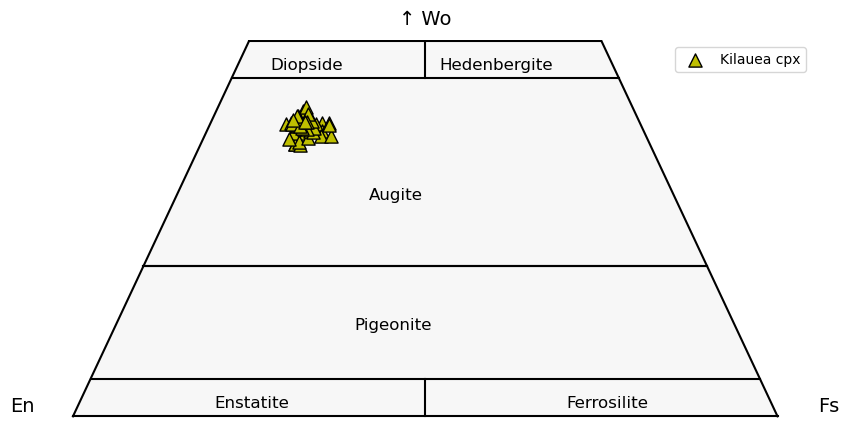

In [16]:
# First, create the ternary plot using Thermobar.
fig, tax = pt.plot_px_classification(figsize=(10, 5),  fontsize_component_labels=12, labels = True)

## Now feed in the Kilauea, natural cpx data in terms of ternary axes!
tax.scatter(Kil_cpx_tern,edgecolor="k",marker="^",
    facecolor="y",label='Kilauea cpx',s=90)

tax.legend()

Let's now add in the clinopyroxene compositions predicted in our crystallization model. We've designed PetThermoTools so that the outputs directly integrate into the Thermobar functions. Try calculating the MELTS pyroxene ternary coordinates by setting **px_comps** to Xtal_LERX['All'] (essentially just loading all the MELTS outputs into Thermobar) in the function below and then plot the results:

In [18]:
############## Calculate the ternary coordinates for the MELTS clinopyroxene. We need to provide a dataframe where there ###############
############## are column headers with the suffix _Cpx ###############
MELTS_cpx_tern = pt.tern_points_px(px_comps= )

**MELTS sometimes stabilizes a clinopyroxene2 phase - this is going to cause a slight issue in thermobar as the outputs have the suffix '_Cpx2' so that the different pyroxene phases are not confused. The easiest way around this is to strip the 2 off the column headers in the 'clinopyroxene2' DataFrame.**

In [17]:
CPX_2_renamedcols=Xtal_LERZ['clinopyroxene2']
CPX_2_renamedcols.head()

In [20]:
# Now strip the two away
CPX_2_renamedcols.columns = CPX_2_renamedcols.columns.str.replace('_Cpx2', '_Cpx')

############## And calculate the ternary points. ###############
MELTS_cpx2_tern = pt.tern_points_px(px_comps= )

In [6]:
# First, create the ternary plot using Thermobar.
fig, tax = pt.plot_px_classification(figsize=(10, 5),  fontsize_component_labels=12, labels = True)

## Now feed in the Kilauea, natural cpx data in terms of ternary axes!
tax.scatter(Kil_cpx_tern, edgecolor="k", marker="^",
    facecolor="y", label='Kilauea cpx', s=90)
tax.scatter(MELTS_cpx_tern, edgecolor="k", marker="o",
    facecolor="k", label='rhyolite-MELTS v1.2.0 Cpx1', s=20)
tax.scatter(MELTS_cpx2_tern, edgecolor="r", marker="o",
    facecolor="r", label='rhyolite-MELTS v1.2.0 Cpx2', s=20)

tax.legend()

**Some questions to think about:**

**- How do the MELTS predictions compare to natural data from Kilauea?**

**- What are the main differences between the predictions and natural data?**

Aside from plotting clinopyroxene compositions within the pyroxene quadrilateral we can also use Thermobar to calculate (in a self-consistent manner) the clinopyroxene components of both the natural data and the MELTS predictions. These calculations return a long-list of compositional parameters, including the cation proportions per 6 oxygens (per formula unit), the Mg#, and the proportions of different components such as Jadeite, Enstatite-Ferrosilite, etc.

Run the code below to calculate the clinopyroxene components for the natural data and MELTS predictions. Have a look at these variables and investigate what parameters are calculated. Following this plot the Mg# of the clinopyroxenes against parameters of your choice. How does the MELTS calculations do in predicting the mineral chemistry?

In [19]:
Kil_cpx_comps = pt.calculate_clinopyroxene_components(cpx_comps=Data['Clinopyroxene'])
MELTS_cpx_comps = pt.calculate_clinopyroxene_components(cpx_comps=Xtal_LERZ['clinopyroxene1'])
MELTS_cpx_comps.head()

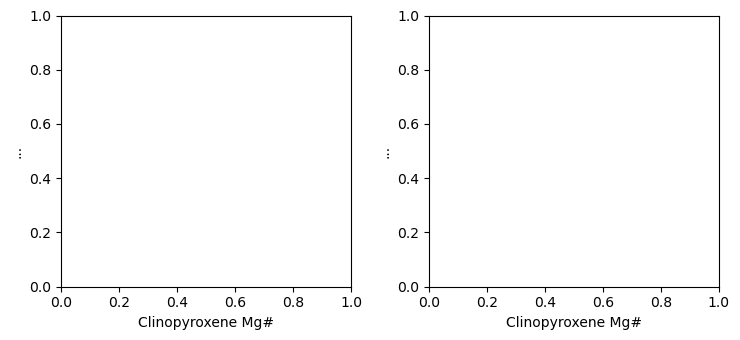

In [10]:
############## Plot up the clinoyproxene Mg#, for both Kilauea and MELTS, against clinopyroxene componenets (e.g., Jadeite). ###############
f, a = plt.subplots(1,2, figsize=(7.5,3.5))
# a[0].scatter(Kil_cpx_comps['Mgno_Cpx'], ..., edgecolor='k', marker = "^", facecolor = 'y', s = 90)
# a[0].scatter(MELTS_cpx_comps['Mgno_Cpx'], ..., edgecolor='k', marker = "o", facecolor = 'k', s = 30)

a[0].set_xlabel('Clinopyroxene Mg#')
a[0].set_ylabel('...')

# a[1].scatter(Kil_cpx_comps['Mgno_Cpx'], ..., edgecolor='k', marker = "^", facecolor = 'y', s = 90)
# a[1].scatter(MELTS_cpx_comps['Mgno_Cpx'], ..., edgecolor='k', marker = "o", facecolor = 'k', s = 30)

a[1].set_xlabel('Clinopyroxene Mg#')
a[1].set_ylabel('...')

f.tight_layout()

**Before we move onto calculations involving sulfur, try plotting the plagioclase chemistry, from both the MELTS models and natural data, on a feldspar ternary diagram. The functions are very similar to those used for the pyroxene quadrilateral shown above, but if you need help have a look at the Thermobar ReadTheDocs page.**

In [27]:
############## Complete the functions by providing the correct data. ###############
Kil_plag_tern=pt.tern_points_fspar(fspar_comps=)
MELTS_plag_tern=pt.tern_points_fspar(fspar_comps=)

In [11]:
# # First, create the ternary plot using Thermobar.
fig, tax = pt.plot_fspar_classification(figsize=(10, 8),  fontsize_component_labels=12, labels = True)

############## Feed in the plagioclase data converted to ternary coordinates. ###############
tax.scatter(Kil_plag_tern, edgecolor="k", marker="^",
    facecolor="y", label='Kilauea plag', s=90)
tax.scatter(MELTS_plag_tern, edgecolor="k", marker="o",
    facecolor="k", label='rhyolite-MELTS v1.2.0', s=20)

tax.legend()

# Part 3 - PySulfSat and PetThermoTools - calculating the SCSS of a crystallizing magma

While MELTS can tell us a lot about the magma during cooling and crystallization there are still many components of magmatic systems that MELTS cannot model directly. One of those is the presence of sulfides and the behaviour of sulfur in magmas more generally. What we can do is use the PetThermoTools outputs to calculate the Sulfur Content at Sulfide Saturation (SCSS). There are many different SCSS models (ask Penny for more details), but in this example we'll just use one of the most recent (O'Neill, 2022).

First, let's plot up the melt-inclusions S contents.

In [19]:
# The probe gives as SO2, lets work out the corr factor to get S
mass_S=32.065
mass_SO2=64.066
factor=10000*mass_S/mass_SO2
factor

5004.9948490619045

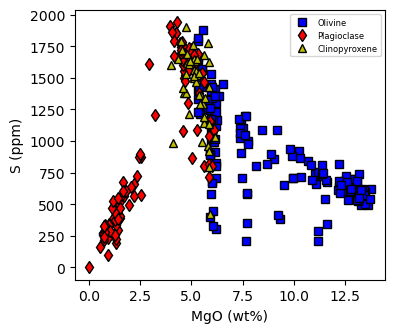

In [20]:
f, a = plt.subplots(1,1, figsize = (4, 3.5))
a.plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['SO2_Liq']*factor, 'sk', mfc = 'b', label = 'Olivine')
a.plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['SO2_Liq']*factor, 'dk', mfc = 'r', label = 'Plagioclase')
a.plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['SO2_Liq']*factor, '^k', mfc = 'y', label = 'Clinopyroxene')

a.set_xlabel('MgO (wt%)')
a.set_ylabel('S (ppm)')
a.legend(fontsize=6)

To see if we can recreate this trend using the information contained in our crystallization models let's use PySulfSat so calculate the SCSS according to the ONeill (2022) model. Plot up the results of the SCSS calculations against the melt inclusion data. 

**After having run the calculations, think about:**
- Do the predictions agree with the data?
- If not, what factors might influence the SCSS that we have not discussed yet (both in the MELTS calculations and in the PySulfSat functions)?
- Try seeing how different variables in the MELTS calculations affect the SCSS.
- What about the parameters in the SCSS functions? For example how does the sulfide composition (Fe_FeNiCu_Sulf) affect the results?

In [21]:
help(ss.calculate_S2017_SCSS)

In [22]:
Smythe_MELTSSuff = ss.calculate_S2017_SCSS(df=Xtal_LERZ['All'], 
                                        T_K=Xtal_LERZ['All']['T_C']+273.15,
                                        P_kbar=Xtal_LERZ['All']['P_bar']/1000,
                                        Fe_FeNiCu_Sulf=0.8,
                                        Fe3Fet_Liq=Xtal_LERZ['All']['Fe3Fet_Liq'])
Smythe_MELTSSuff.head()

,SCSS2_ppm_ideal_Smythe2017,SCSS2_ppm_ideal_Smythe2017_1sigma,T_Input_K,P_Input_kbar,Fe_FeNiCu_Sulf,Fe3Fet_Liq_input,Si_wt_atom,Ti_wt_atom,Al_wt_atom,Mg_wt_atom,Mn_wt_atom,Fe2_wt_atom,Fe3_wt_atom,Ca_wt_atom,Na_wt_atom,K_wt_atom,P_wt_atom,H_wt_atom,Si_XA_ideal,Ti_XA_ideal,Al_XA_ideal,Mg_XA_ideal,Fe2_XA_ideal,Ca_XA_ideal,Na_XA_ideal,K_XA_ideal,H_XA_ideal,Si*Fe_ideal,Si_XA_non_ideal,Ti_XA_non_ideal,Al_XA_non_ideal,Mg_XA_non_ideal,Fe2_XA_non_ideal,Ca_XA_non_ideal,Na_XA_non_ideal,K_XA_non_ideal,H_XA_non_ideal,Si*Fe_non_ideal,log_SCSS_ideal,Fe_FeNiCu_Sulf_calc,T_C,P_bar,mass_g,h_J,s_J/K,v_cm3,rho_kg/m3,log10(fO2),dvdp_cm3/bar,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq,mass_g_Liq,rho_kg/m3_Liq,v_cm3_Liq,g_J_Liq,h_J_Liq,s_J/K_Liq,cp_J/kg/K_Liq,dcpdt_J/K_Liq,dvdt_cm3/K_Liq,dpdt_bar/K_Liq,d2vdt2_cm3/K2_Liq,d2vdtdp_cm3/bar.K_Liq,d2vdp2_cm3/bar2_Liq,molwt_Liq,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,Cr2O3_Cpx,Fe2O3_Cpx,FeO_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,P2O5_Cpx,H2O_Cpx,CO2_Cpx,Fe3Fet_Cpx,mass_g_Cpx,rho_kg/m3_Cpx,v_cm3_Cpx,g_J_Cpx,h_J_Cpx,s_J/K_Cpx,cp_J/kg/K_Cpx,dcpdt_J/K_Cpx,dvdt_cm3/K_Cpx,dpdt_bar/K_Cpx,d2vdt2_cm3/K2_Cpx,d2vdtdp_cm3/bar.K_Cpx,d2vdp2_cm3/bar2_Cpx,molwt_Cpx,SiO2_Plag,TiO2_Plag,Al2O3_Plag,Cr2O3_Plag,Fe2O3_Plag,FeO_Plag,FeOt_Plag,MnO_Plag,MgO_Plag,CaO_Plag,Na2O_Plag,K2O_Plag,P2O5_Plag,H2O_Plag,CO2_Plag,Fe3Fet_Plag,mass_g_Plag,rho_kg/m3_Plag,v_cm3_Plag,g_J_Plag,h_J_Plag,s_J/K_Plag,cp_J/kg/K_Plag,dcpdt_J/K_Plag,dvdt_cm3/K_Plag,dpdt_bar/K_Plag,d2vdt2_cm3/K2_Plag,d2vdtdp_cm3/bar.K_Plag,d2vdp2_cm3/bar2_Plag,molwt_Plag,SiO2_Cpx2,TiO2_Cpx2,Al2O3_Cpx2,Cr2O3_Cpx2,Fe2O3_Cpx2,FeO_Cpx2,FeOt_Cpx2,MnO_Cpx2,MgO_Cpx2,CaO_Cpx2,Na2O_Cpx2,K2O_Cpx2,P2O5_Cpx2,H2O_Cpx2,CO2_Cpx2,Fe3Fet_Cpx2,mass_g_Cpx2,rho_kg/m3_Cpx2,v_cm3_Cpx2,g_J_Cpx2,h_J_Cpx2,s_J/K_Cpx2,cp_J/kg/K_Cpx2,dcpdt_J/K_Cpx2,dvdt_cm3/K_Cpx2,dpdt_bar/K_Cpx2,d2vdt2_cm3/K2_Cpx2,d2vdtdp_cm3/bar.K_Cpx2,d2vdp2_cm3/bar2_Cpx2,molwt_Cpx2,SiO2_Sp,TiO2_Sp,Al2O3_Sp,Cr2O3_Sp,Fe2O3_Sp,FeO_Sp,FeOt_Sp,MnO_Sp,MgO_Sp,CaO_Sp,Na2O_Sp,K2O_Sp,P2O5_Sp,H2O_Sp,CO2_Sp,Fe3Fet_Sp,mass_g_Sp,rho_kg/m3_Sp,v_cm3_Sp,g_J_Sp,h_J_Sp,s_J/K_Sp,cp_J/kg/K_Sp,dcpdt_J/K_Sp,dvdt_cm3/K_Sp,dpdt_bar/K_Sp,d2vdt2_cm3/K2_Sp,d2vdtdp_cm3/bar.K_Sp,d2vdp2_cm3/bar2_Sp,molwt_Sp,SiO2_Rhm,TiO2_Rhm,Al2O3_Rhm,Cr2O3_Rhm,Fe2O3_Rhm,FeO_Rhm,FeOt_Rhm,MnO_Rhm,MgO_Rhm,CaO_Rhm,Na2O_Rhm,K2O_Rhm,P2O5_Rhm,H2O_Rhm,CO2_Rhm,Fe3Fet_Rhm,mass_g_Rhm,rho_kg/m3_Rhm,v_cm3_Rhm,g_J_Rhm,h_J_Rhm,s_J/K_Rhm,cp_J/kg/K_Rhm,dcpdt_J/K_Rhm,dvdt_cm3/K_Rhm,dpdt_bar/K_Rhm,d2vdt2_cm3/K2_Rhm,d2vdtdp_cm3/bar.K_Rhm,d2vdp2_cm3/bar2_Rhm,molwt_Rhm,SiO2_Ol,TiO2_Ol,Al2O3_Ol,Cr2O3_Ol,Fe2O3_Ol,FeO_Ol,FeOt_Ol,MnO_Ol,MgO_Ol,CaO_Ol,Na2O_Ol,K2O_Ol,P2O5_Ol,H2O_Ol,CO2_Ol,Fe3Fet_Ol,mass_g_Ol,rho_kg/m3_Ol,v_cm3_Ol,g_J_Ol,h_J_Ol,s_J/K_Ol,cp_J/kg/K_Ol,dcpdt_J/K_Ol,dvdt_cm3/K_Ol,dpdt_bar/K_Ol,d2vdt2_cm3/K2_Ol,d2vdtdp_cm3/bar.K_Ol,d2vdp2_cm3/bar2_Ol,molwt_Ol,SiO2_Apa,TiO2_Apa,Al2O3_Apa,Cr2O3_Apa,Fe2O3_Apa,FeO_Apa,FeOt_Apa,MnO_Apa,MgO_Apa,CaO_Apa,Na2O_Apa,K2O_Apa,P2O5_Apa,H2O_Apa,CO2_Apa,Fe3Fet_Apa,mass_g_Apa,rho_kg/m3_Apa,v_cm3_Apa,g_J_Apa,h_J_Apa,s_J/K_Apa,cp_J/kg/K_Apa,dcpdt_J/K_Apa,dvdt_cm3/K_Apa,dpdt_bar/K_Apa,d2vdt2_cm3/K2_Apa,d2vdtdp_cm3/bar.K_Apa,d2vdp2_cm3/bar2_Apa,molwt_Apa,SiO2_Qtz,TiO2_Qtz,Al2O3_Qtz,Cr2O3_Qtz,Fe2O3_Qtz,FeO_Qtz,FeOt_Qtz,MnO_Qtz,MgO_Qtz,CaO_Qtz,Na2O_Qtz,K2O_Qtz,P2O5_Qtz,H2O_Qtz,CO2_Qtz,Fe3Fet_Qtz,mass_g_Qtz,rho_kg/m3_Qtz,v_cm3_Qtz,g_J_Qtz,h_J_Qtz,s_J/K_Qtz,cp_J/kg/K_Qtz,dcpdt_J/K_Qtz,dvdt_cm3/K_Qtz,dpdt_bar/K_Qtz,d2vdt2_cm3/K2_Qtz,d2vdtdp_cm3/bar.K_Qtz,d2vdp2_cm3/bar2_Qtz,molwt_Qtz,Fe_FeNiCu_Sulf_calc
0,1269.443191,346.773511,1442.527185,0.65,0.8,0.179908,0.479172,0.018223,0.148492,0.092996,0.001443,0.070950,0.015562,0.109535,0.043497,0.005797,0.001923,0.012411,-13206.467197,-204.476542,-2739.712013,-1299.125480,-2431.759734,-857.749069,-576.196771,-168.185010,-217.128649,3962.986624,-13415.092246,-195.264618,-2821.330826,-1349.605462,-2475.828327,-967.367208,-596.464

In [23]:
# run the SCSS function
ONeill_MELTSSulf=ss.calculate_O2021_SCSS(df=Xtal_LERZ['All'], 
                                        T_K=Xtal_LERZ['All']['T_C']+273.15,
                                        P_kbar=Xtal_LERZ['All']['P_bar']/1000,
                                        Fe_FeNiCu_Sulf=0.8,
                                        Fe3Fet_Liq=Xtal_LERZ['All']['Fe3Fet_Liq'])
ONeill_MELTSSulf.head()

,SCSS2_ppm,LnS,Ln_a_FeO,Ln_a_FeS,DeltaG,LnCS2_calc,T_C,P_bar,mass_g,h_J,s_J/K,v_cm3,rho_kg/m3,log10(fO2),dvdp_cm3/bar,SiO2_Liq,TiO2_Liq,Al2O3_Liq,Cr2O3_Liq,Fe2O3_Liq,FeO_Liq,FeOt_Liq,MnO_Liq,MgO_Liq,CaO_Liq,Na2O_Liq,K2O_Liq,P2O5_Liq,H2O_Liq,CO2_Liq,Fe3Fet_Liq,mass_g_Liq,rho_kg/m3_Liq,v_cm3_Liq,g_J_Liq,h_J_Liq,s_J/K_Liq,cp_J/kg/K_Liq,dcpdt_J/K_Liq,dvdt_cm3/K_Liq,dpdt_bar/K_Liq,d2vdt2_cm3/K2_Liq,d2vdtdp_cm3/bar.K_Liq,d2vdp2_cm3/bar2_Liq,molwt_Liq,SiO2_Cpx,TiO2_Cpx,Al2O3_Cpx,Cr2O3_Cpx,Fe2O3_Cpx,FeO_Cpx,FeOt_Cpx,MnO_Cpx,MgO_Cpx,CaO_Cpx,Na2O_Cpx,K2O_Cpx,P2O5_Cpx,H2O_Cpx,CO2_Cpx,Fe3Fet_Cpx,mass_g_Cpx,rho_kg/m3_Cpx,v_cm3_Cpx,g_J_Cpx,h_J_Cpx,s_J/K_Cpx,cp_J/kg/K_Cpx,dcpdt_J/K_Cpx,dvdt_cm3/K_Cpx,dpdt_bar/K_Cpx,d2vdt2_cm3/K2_Cpx,d2vdtdp_cm3/bar.K_Cpx,d2vdp2_cm3/bar2_Cpx,molwt_Cpx,SiO2_Plag,TiO2_Plag,Al2O3_Plag,Cr2O3_Plag,Fe2O3_Plag,FeO_Plag,FeOt_Plag,MnO_Plag,MgO_Plag,CaO_Plag,Na2O_Plag,K2O_Plag,P2O5_Plag,H2O_Plag,CO2_Plag,Fe3Fet_Plag,mass_g_Plag,rho_kg/m3_Plag,v_cm3_Plag,g_J_Plag,h_J_Plag,s_J/K_Plag,cp_J/kg/K_Plag,dcpdt_J/K_Plag,dvdt_cm3/K_Plag,dpdt_bar/K_Plag,d2vdt2_cm3/K2_Plag,d2vdtdp_cm3/bar.K_Plag,d2vdp2_cm3/bar2_Plag,molwt_Plag,SiO2_Cpx2,TiO2_Cpx2,Al2O3_Cpx2,Cr2O3_Cpx2,Fe2O3_Cpx2,FeO_Cpx2,FeOt_Cpx2,MnO_Cpx2,MgO_Cpx2,CaO_Cpx2,Na2O_Cpx2,K2O_Cpx2,P2O5_Cpx2,H2O_Cpx2,CO2_Cpx2,Fe3Fet_Cpx2,mass_g_Cpx2,rho_kg/m3_Cpx2,v_cm3_Cpx2,g_J_Cpx2,h_J_Cpx2,s_J/K_Cpx2,cp_J/kg/K_Cpx2,dcpdt_J/K_Cpx2,dvdt_cm3/K_Cpx2,dpdt_bar/K_Cpx2,d2vdt2_cm3/K2_Cpx2,d2vdtdp_cm3/bar.K_Cpx2,d2vdp2_cm3/bar2_Cpx2,molwt_Cpx2,SiO2_Sp,TiO2_Sp,Al2O3_Sp,Cr2O3_Sp,Fe2O3_Sp,FeO_Sp,FeOt_Sp,MnO_Sp,MgO_Sp,CaO_Sp,Na2O_Sp,K2O_Sp,P2O5_Sp,H2O_Sp,CO2_Sp,Fe3Fet_Sp,mass_g_Sp,rho_kg/m3_Sp,v_cm3_Sp,g_J_Sp,h_J_Sp,s_J/K_Sp,cp_J/kg/K_Sp,dcpdt_J/K_Sp,dvdt_cm3/K_Sp,dpdt_bar/K_Sp,d2vdt2_cm3/K2_Sp,d2vdtdp_cm3/bar.K_Sp,d2vdp2_cm3/bar2_Sp,molwt_Sp,SiO2_Rhm,TiO2_Rhm,Al2O3_Rhm,Cr2O3_Rhm,Fe2O3_Rhm,FeO_Rhm,FeOt_Rhm,MnO_Rhm,MgO_Rhm,CaO_Rhm,Na2O_Rhm,K2O_Rhm,P2O5_Rhm,H2O_Rhm,CO2_Rhm,Fe3Fet_Rhm,mass_g_Rhm,rho_kg/m3_Rhm,v_cm3_Rhm,g_J_Rhm,h_J_Rhm,s_J/K_Rhm,cp_J/kg/K_Rhm,dcpdt_J/K_Rhm,dvdt_cm3/K_Rhm,dpdt_bar/K_Rhm,d2vdt2_cm3/K2_Rhm,d2vdtdp_cm3/bar.K_Rhm,d2vdp2_cm3/bar2_Rhm,molwt_Rhm,SiO2_Ol,TiO2_Ol,Al2O3_Ol,Cr2O3_Ol,Fe2O3_Ol,FeO_Ol,FeOt_Ol,MnO_Ol,MgO_Ol,CaO_Ol,Na2O_Ol,K2O_Ol,P2O5_Ol,H2O_Ol,CO2_Ol,Fe3Fet_Ol,mass_g_Ol,rho_kg/m3_Ol,v_cm3_Ol,g_J_Ol,h_J_Ol,s_J/K_Ol,cp_J/kg/K_Ol,dcpdt_J/K_Ol,dvdt_cm3/K_Ol,dpdt_bar/K_Ol,d2vdt2_cm3/K2_Ol,d2vdtdp_cm3/bar.K_Ol,d2vdp2_cm3/bar2_Ol,molwt_Ol,SiO2_Apa,TiO2_Apa,Al2O3_Apa,Cr2O3_Apa,Fe2O3_Apa,FeO_Apa,FeOt_Apa,MnO_Apa,MgO_Apa,CaO_Apa,Na2O_Apa,K2O_Apa,P2O5_Apa,H2O_Apa,CO2_Apa,Fe3Fet_Apa,mass_g_Apa,rho_kg/m3_Apa,v_cm3_Apa,g_J_Apa,h_J_Apa,s_J/K_Apa,cp_J/kg/K_Apa,dcpdt_J/K_Apa,dvdt_cm3/K_Apa,dpdt_bar/K_Apa,d2vdt2_cm3/K2_Apa,d2vdtdp_cm3/bar.K_Apa,d2vdp2_cm3/bar2_Apa,molwt_Apa,SiO2_Qtz,TiO2_Qtz,Al2O3_Qtz,Cr2O3_Qtz,Fe2O3_Qtz,FeO_Qtz,FeOt_Qtz,MnO_Qtz,MgO_Qtz,CaO_Qtz,Na2O_Qtz,K2O_Qtz,P2O5_Qtz,H2O_Qtz,CO2_Qtz,Fe3Fet_Qtz,mass_g_Qtz,rho_kg/m3_Qtz,v_cm3_Qtz,g_J_Qtz,h_J_Qtz,s_J/K_Qtz,cp_J/kg/K_Qtz,dcpdt_J/K_Qtz,dvdt_cm3/K_Qtz,dpdt_bar/K_Qtz,d2vdt2_cm3/K2_Qtz,d2vdtdp_cm3/bar.K_Qtz,d2vdp2_cm3/bar2_Qtz,molwt_Qtz,Fe_FeNiCu_Sulf_calc
0,1431.130287,7.266220,-2.329823,-0.297848,7.880999,-2.646755,1169.377185,650.0,100.000000,-1.205208e+06,264.736725,37.272109,2682.971350,-8.203467,-0.000243,51.393844,2.599136,13.513474,0.0,2.218538,9.099614,11.095840,0.182752,6.690743,10.965103,2.406231,0.487338,0,0.199558,0.0,0.179908,100.000000,2682.971350,37.272109,-1.587098e+06,-1.205208e+06,264.736725,1445.356146,0.001145,0.002698,NaN,6.568958e-08,-6.841595e-09,9.418828e-09,95.856205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.0,0.000000e+00,0.0,0.000000e+00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

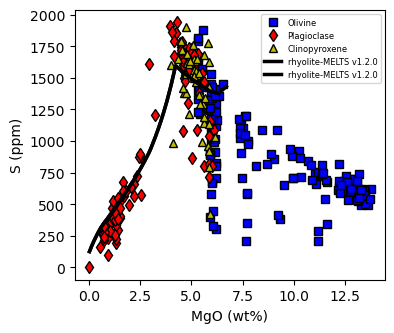

In [24]:
f, a = plt.subplots(1,1, figsize = (4, 3.5))
a.plot(Data['Olivine']['MgO_Liq'], Data['Olivine']['SO2_Liq']*factor, 'sk', mfc = 'b', label = 'Olivine')
a.plot(Data['Plagioclase']['MgO_Liq'], Data['Plagioclase']['SO2_Liq']*factor, 'dk', mfc = 'r', label = 'Plagioclase')
a.plot(Data['Clinopyroxene']['MgO_Liq'], Data['Clinopyroxene']['SO2_Liq']*factor, '^k', mfc = 'y', label = 'Clinopyroxene')
a.plot(Xtal_LERZ['All']['MgO_Liq'], ONeill_MELTSSulf['SCSS2_ppm'], '-k', lw = 2.5, label = 'rhyolite-MELTS v1.2.0')
a.plot(Xtal_LERZ['All']['MgO_Liq'], ONeill_MELTSSulf['SCSS2_ppm'], '-k', lw = 2.5, label = 'rhyolite-MELTS v1.2.0')

a.set_xlabel('MgO (wt%)')
a.set_ylabel('S (ppm)')
a.legend(fontsize=6)

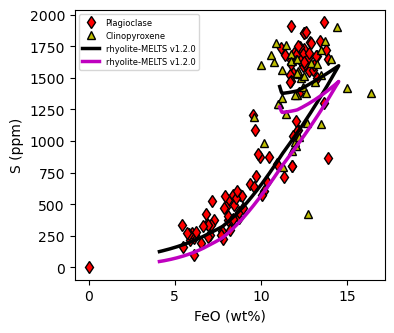

In [25]:
f, a = plt.subplots(1,1, figsize = (4, 3.5))
#a.plot(Data['Olivine']['FeOt_Liq'], Data['Olivine']['SO2_Liq']*factor, 'sk', mfc = 'b', label = 'Olivine')
a.plot(Data['Plagioclase']['FeOt_Liq'], Data['Plagioclase']['SO2_Liq']*factor, 'dk', mfc = 'r', label = 'Plagioclase')
a.plot(Data['Clinopyroxene']['FeOt_Liq'], Data['Clinopyroxene']['SO2_Liq']*factor, '^k', mfc = 'y', label = 'Clinopyroxene')
a.plot(Xtal_LERZ['All']['FeOt_Liq'], ONeill_MELTSSulf['SCSS2_ppm'], '-k', lw = 2.5, label = 'rhyolite-MELTS v1.2.0')
a.plot(Xtal_LERZ['All']['FeOt_Liq'], Smythe_MELTSSuff['SCSS2_ppm_ideal_Smythe2017'], '-m', lw = 2.5, label = 'rhyolite-MELTS v1.2.0')

a.set_xlabel('FeO (wt%)')
a.set_ylabel('S (ppm)')
a.legend(fontsize=6)